#Assignment Target

Test Accuracy: 99.4

Total Number of Parameters: 8000

#Results obtained in Sixth Submission

Best Test Accuracy: 99.42

Number of Parameters Used: 7640

#RF & Other Dimension Calculations - 

Since we have not added any new layers, so RF and other dimensionality calculations remain same.

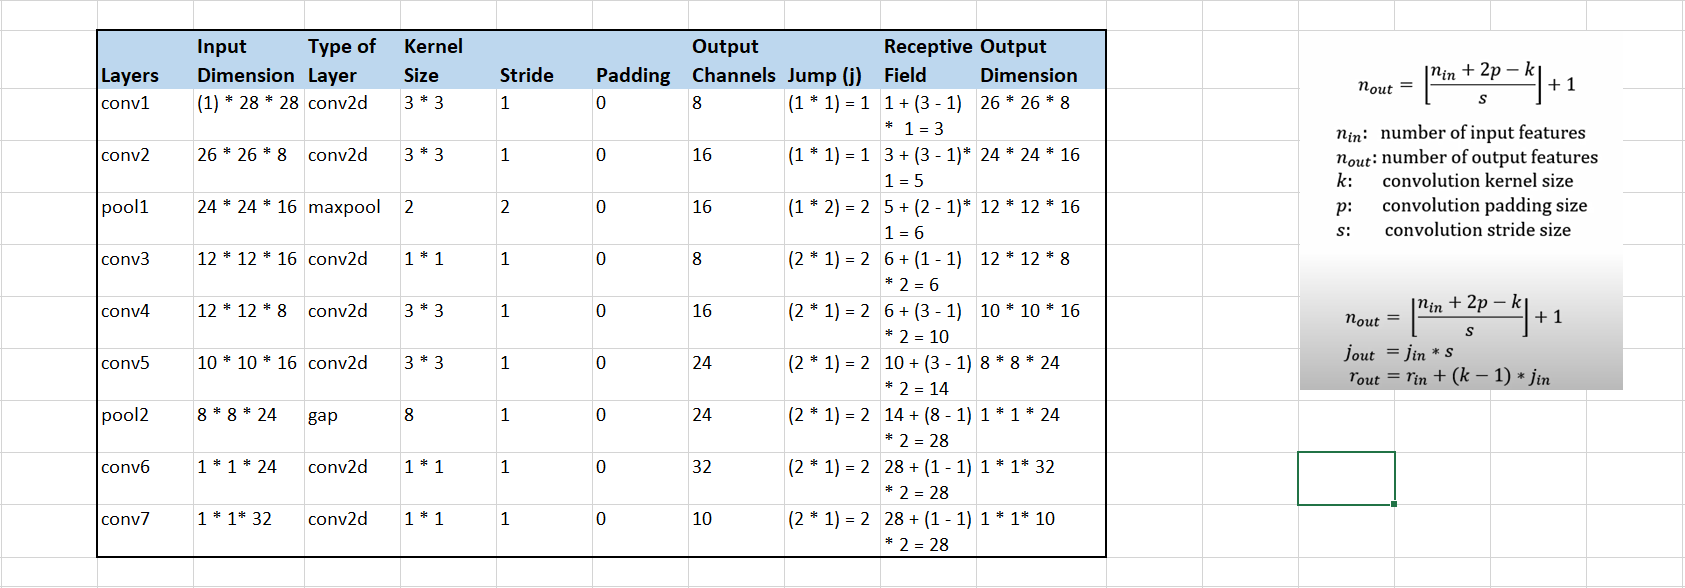

#Analysis - Test Accuracy Progression and lets see train accuracy as well

From 6th epoch (starting from 0), we could consistently achieve over 99% test accuracy. Moreover, last recorded training accuracy came as 97.84. That means there is a genuine chance of improving test accuracy beyond 99.5 if its trained for more number of epochs. I think its good that training accuracy isn't touching 99, as we have used compariively simpler model and hence chance for getting overfitted would be lower.

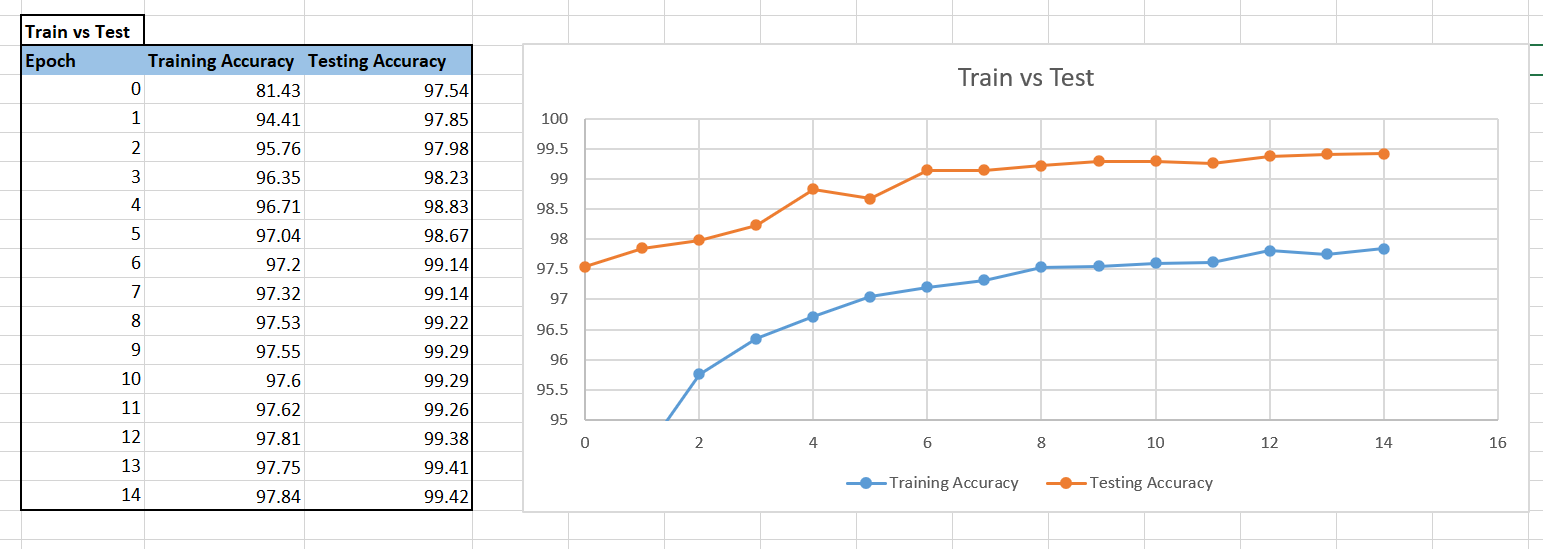

#Comments

1. We could achieve target test accuracy while using lesser than 8k parameters. Moreover in the convoluions we used, we have made bias as false, hence there's less number of trainable parameters. We used SGD optimizer with StepLR for reaching the desired accuracy. SGD's learning rate is kept as 0.01, and momentum we kept at 0.9. Step size we used as 6, with gamma value as 0.1.

# Import Libraries

In [36]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

In [37]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [38]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [39]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model


In [40]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, bias=False) # 26 * 26 * 8
        self.bn1 = nn.BatchNorm2d(8) # 26 * 26 * 8
        self.conv2 = nn.Conv2d(8, 16, 3, bias=False) # 24 * 24 * 16
        self.bn2 = nn.BatchNorm2d(16) # 24 * 24 * 16
        self.pool1 = nn.MaxPool2d(2, 2) # 12 * 12 * 16
        self.conv3 = nn.Conv2d(16, 8, 1, bias=False) # 12 * 12 * 8
        self.bn3 = nn.BatchNorm2d(8) # 12 * 12 * 8

        self.conv4 = nn.Conv2d(8, 16, 3, bias=False) # 10 * 10 * 16
        self.bn4 = nn.BatchNorm2d(16) # 10 * 10 * 16
        self.conv5 = nn.Conv2d(16, 24, 3, bias=False) # 8 * 8 * 24
        self.bn5 = nn.BatchNorm2d(24) # 8 * 8 * 24

        

        self.pool2 = nn.AvgPool2d(8) # 1 * 1 * 24

        self.conv6 = nn.Conv2d(24, 32, 1, bias=False) # 1 * 1 * 32
        self.bn6 = nn.BatchNorm2d(32) # 1 * 1 * 32
        self.conv7 = nn.Conv2d(32, 16, 1, bias=False) # 1 * 1 * 16
        self.bn7 = nn.BatchNorm2d(16) # 1 * 1 * 16
        self.conv8 = nn.Conv2d(16, 10, 1, bias=False) # 1 * 1 * 10

        self.dropout = nn.Dropout(0.03)
        

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.dropout(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = self.bn4(x)
        x = self.dropout(x)

        x = self.conv5(x)
        x = F.relu(x)
        x = self.bn5(x)
        x = self.dropout(x)
        x = self.pool2(x)

        x = self.conv6(x)
        x = F.relu(x)
        x = self.bn6(x)
        x = self.dropout(x)

        x = self.conv7(x)
        x = F.relu(x)
        x = self.bn7(x)
        x = self.dropout(x)

        x = self.conv8(x)

        '''
        x = nn.Dropout(self.bn3(self.conv3(self.pool1(nn.Dropout(self.bn2(self.conv2(F.relu(nn.Dropout(self.bn1(self.conv1(x)), 0.05)))), 0.05)))), 0.05)
        x = self.pool2(nn.Dropout(self.bn5(F.relu(self.conv5(nn.Dropout(self.bn4(F.relu(self.conv4(x))), 0.05)))), 0.05)),
        x = self.conv8(nn.Dropout(self.bn7(F.relu(self.conv7(nn.Dropout(self.bn6(F.relu(self.conv6(x))), 0.05)))), 0.05))
        '''
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params

In [41]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
       BatchNorm2d-2            [-1, 8, 26, 26]              16
           Dropout-3            [-1, 8, 26, 26]               0
            Conv2d-4           [-1, 16, 24, 24]           1,152
       BatchNorm2d-5           [-1, 16, 24, 24]              32
           Dropout-6           [-1, 16, 24, 24]               0
         MaxPool2d-7           [-1, 16, 12, 12]               0
            Conv2d-8            [-1, 8, 12, 12]             128
       BatchNorm2d-9            [-1, 8, 12, 12]              16
          Dropout-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
      BatchNorm2d-12           [-1, 16, 10, 10]              32

# Training and Testing

In [42]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's Train and test our model

In [43]:
from torch.optim.lr_scheduler import LambdaLR, StepLR, OneCycleLR
target_accuracy = 99.4


model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum= 0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)



EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    #scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.27262410521507263 Batch_id=468 Accuracy=81.43: 100%|██████████| 469/469 [00:38<00:00, 12.11it/s]



Test set: Average loss: 0.0810, Accuracy: 9754/10000 (97.54%)

EPOCH: 1


Loss=0.25788623094558716 Batch_id=468 Accuracy=94.41: 100%|██████████| 469/469 [00:35<00:00, 13.04it/s]



Test set: Average loss: 0.0645, Accuracy: 9785/10000 (97.85%)

EPOCH: 2


Loss=0.13935916125774384 Batch_id=468 Accuracy=95.76: 100%|██████████| 469/469 [00:35<00:00, 13.17it/s]



Test set: Average loss: 0.0649, Accuracy: 9798/10000 (97.98%)

EPOCH: 3


Loss=0.11832254379987717 Batch_id=468 Accuracy=96.35: 100%|██████████| 469/469 [00:34<00:00, 13.65it/s]



Test set: Average loss: 0.0569, Accuracy: 9823/10000 (98.23%)

EPOCH: 4


Loss=0.12303054332733154 Batch_id=468 Accuracy=96.71: 100%|██████████| 469/469 [00:34<00:00, 13.62it/s]



Test set: Average loss: 0.0346, Accuracy: 9883/10000 (98.83%)

EPOCH: 5


Loss=0.05285732075572014 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:34<00:00, 13.64it/s]



Test set: Average loss: 0.0428, Accuracy: 9867/10000 (98.67%)

EPOCH: 6


Loss=0.0554448626935482 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:35<00:00, 13.09it/s]



Test set: Average loss: 0.0272, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.04172109439969063 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:34<00:00, 13.51it/s]



Test set: Average loss: 0.0309, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.06748926639556885 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:34<00:00, 13.74it/s]



Test set: Average loss: 0.0246, Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.12525376677513123 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:34<00:00, 13.64it/s]



Test set: Average loss: 0.0247, Accuracy: 9929/10000 (99.29%)

EPOCH: 10


Loss=0.1687525361776352 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:34<00:00, 13.68it/s]



Test set: Average loss: 0.0244, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.09009213000535965 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:36<00:00, 13.00it/s]



Test set: Average loss: 0.0230, Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.12872128188610077 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:34<00:00, 13.56it/s]



Test set: Average loss: 0.0213, Accuracy: 9938/10000 (99.38%)

EPOCH: 13


Loss=0.035853102803230286 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:34<00:00, 13.71it/s]



Test set: Average loss: 0.0179, Accuracy: 9941/10000 (99.41%)

EPOCH: 14


Loss=0.08171842247247696 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:34<00:00, 13.71it/s]



Test set: Average loss: 0.0168, Accuracy: 9942/10000 (99.42%)

